# 6. Recurrent Neural Networks and Language Models

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://github.com/pytorch/examples/tree/master/word_language_model
* https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/language_model

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy

flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)
USE_CUDA = torch.cuda.is_available()
gpus = [0]
# torch.cuda.set_device(gpus[0])
FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<unk>"], seq))
    return LongTensor(idxs)

## Data load and Preprocessing

### Penn TreeBank

In [4]:
import codecs
def prepare_ptb_dataset(filename, word2index=None):
    corpus = codecs.open(filename, 'r', encoding='utf-8').readlines()
    corpus = flatten([co.strip().split() + ['</s>'] for co in corpus])
    
    if word2index == None:
        vocab = list(set(corpus))
        word2index = {'<unk>': 0}
        for vo in vocab:
            if word2index.get(vo) is None:
                word2index[vo] = len(word2index)
    
    return prepare_sequence(corpus, word2index), word2index

In [5]:
# borrowed code from https://github.com/pytorch/examples/tree/master/word_language_model

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).contiguous()
    if USE_CUDA:
        data = data.cuda()
    return data

In [6]:
def getBatch(data, seq_length):
     for i in range(0, data.size(1) - seq_length, seq_length):
        inputs = Variable(data[:, i: i + seq_length])
        targets = Variable(data[:, (i + 1): (i + 1) + seq_length].contiguous())
        yield (inputs, targets)

In [7]:
train_data, word2index = prepare_ptb_dataset('../dataset/ptb/ptb.train.txt',)
dev_data , _ = prepare_ptb_dataset('../dataset/ptb/ptb.valid.txt', word2index)
test_data, _ = prepare_ptb_dataset('../dataset/ptb/ptb.test.txt', word2index)

In [8]:
len(word2index)

10000

In [9]:
index2word = {v:k for k, v in word2index.items()}

## Modeling 

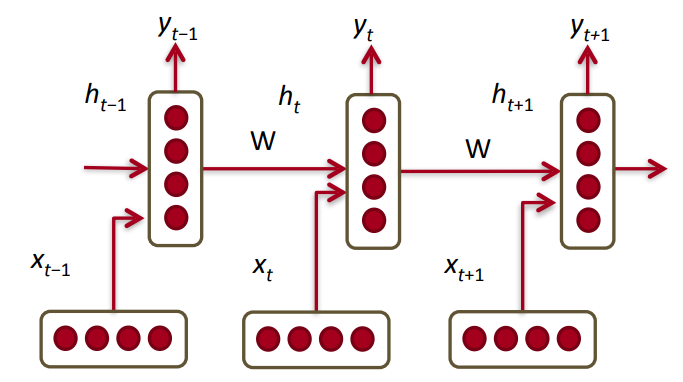

In [10]:
# borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture8.pdf
from IPython.display import Image
Image(filename='../images/06.rnnlm-architecture.png')

In [11]:
class LanguageModel(nn.Module): 
    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.5):

        super(LanguageModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_p)
        
    def init_weight(self):
        self.embed.weight = nn.init.xavier_uniform_(self.embed.weight)
        self.linear.weight = nn.init.xavier_uniform_(self.linear.weight)
        self.linear.bias.data.fill_(0)
        
    def init_hidden(self,batch_size):
        hidden = Variable(torch.zeros(self.n_layers,batch_size,self.hidden_size))
        context = Variable(torch.zeros(self.n_layers,batch_size,self.hidden_size))
        return (hidden.cuda(), context.cuda()) if USE_CUDA else (hidden, context)
    
    def detach_hidden(self, hiddens):
        return tuple([hidden.detach() for hidden in hiddens])
    
    def forward(self, inputs, hidden, is_training=False): 
        embeds = self.embed(inputs)
        if is_training:
            embeds = self.dropout(embeds)
        out,hidden = self.rnn(embeds, hidden)
        return self.linear(out.contiguous().view(out.size(0) * out.size(1), -1)), hidden

## Train 

It takes for a while...

In [12]:
EMBED_SIZE = 128
HIDDEN_SIZE = 1024
NUM_LAYER = 1
LR = 0.01
SEQ_LENGTH = 30 # for bptt
BATCH_SIZE = 20
EPOCH = 40
RESCHEDULED = False

In [13]:
train_data = batchify(train_data, BATCH_SIZE)
dev_data = batchify(dev_data, BATCH_SIZE//2)
test_data = batchify(test_data, BATCH_SIZE//2)

In [14]:
model = LanguageModel(len(word2index), EMBED_SIZE, HIDDEN_SIZE, NUM_LAYER, 0.5)
model.init_weight() 
if USE_CUDA:
    model = model.cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [16]:
for epoch in range(EPOCH):
    total_loss = 0
    losses = []
    hidden = model.init_hidden(BATCH_SIZE)
    for i,batch in enumerate(getBatch(train_data, SEQ_LENGTH)):
        inputs, targets = batch
        hidden = model.detach_hidden(hidden)
        model.zero_grad()
        preds, hidden = model(inputs, hidden, True)

        loss = loss_function(preds, targets.view(-1))
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # gradient clipping
        optimizer.step()

        if i > 0 and i % 500 == 0:
            print("[%02d/%d] mean_loss : %0.2f, Perplexity : %0.2f" % (epoch,EPOCH, np.mean(losses), np.exp(np.mean(losses))))
            losses = []
        
    # learning rate anealing
    # You can use http://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate
    if RESCHEDULED == False and epoch == EPOCH//2:
        LR *= 0.1
        optimizer = optim.Adam(model.parameters(), lr=LR)
        RESCHEDULED = True

KeyboardInterrupt: 

### Test 

In [ ]:
total_loss = 0
hidden = model.init_hidden(BATCH_SIZE//2)
for batch in getBatch(test_data, SEQ_LENGTH):
    inputs,targets = batch
        
    hidden = model.detach_hidden(hidden)
    model.zero_grad()
    preds, hidden = model(inputs, hidden)
    total_loss += inputs.size(1) * loss_function(preds, targets.view(-1)).data

total_loss = total_loss[0]/test_data.size(1)
print("Test Perpelexity : %5.2f" % (np.exp(total_loss)))

## Further topics

* <a href="https://arxiv.org/pdf/1609.07843.pdf">Pointer Sentinel Mixture Models</a>
* <a href="https://arxiv.org/pdf/1708.02182">Regularizing and Optimizing LSTM Language Models</a>